# Link: https://patches12306.github.io/patches12306/


# Final Tutorial Milestone 1: “Can you [Google] the stock market?"
### Data Science Project by <em>Garrett Van Beek</em> and <em>Ben Nguyen</em>
### Intro to data Science
### Professor Nick Mattei

## Overview
In our project, we searched for a correlation between internet popularity and stock performance of certain stocks. By internet popularity we mean (1) Google Search frequency and (2) computed twitter sentiment*. This is what we meant by the ambitious title <strong>"Can we Google the stock market?"</strong>. This can be applied to many stocks, for testing purposes, we used Elon Musk's internet popularity vs. TESLA and PAYPAL stock performance.

#### I. Research Question and Hypothesis
**Research Questions:** Is there a correlation between Elon Musk's internet popularity and the performance of TESLA and PAYPAL stocks?
What is a better indicator of stock performance: Twitter or Google Search Trends?

**Hypotheses:** There will be a positive correlation between Elon Musk's internet popularity (google search trends/twitter sentiment) and the performance of PAYPAL and TESLA stocks.
Twitter Sentiment will be a better indicator of stock performance because it is a measure of public sentiment towards the stock.


#### II. Data Collection
We collected data from Google trends, Twitter using Tweepy API, and Yahoo Finance. Our goal was to find a relation between internet popularity and stock performance.

#### III. Data Processing
We ran a sentiment analysis on all the replies on twitter to @elonmusk using a package called textblob. Textblob is a natural language processor that computes the sentiment of text using to metrics: polarity (-1 to 1) and subjectivity (0 to 1).

#### IV. Exploratory analysis and data visualization
We computed linear regressions, and correlation coefficients for sentiment from google trends data vs. stock performance.
We couldn't gather enough Twitter data to compute meaningful correlation coefficients and linear regression about twitter sentiment, so instead we made some visualizations of tweet frequency over time. 

#### V. Analysis, Hypothesis Testing
In our analysis we conclude that there was a correlation between Google Search Trends and stock performance. However, correlation does not mean causation, so this correlation tells us very little. By looking at our visualization of tweets in reply to Elon Musk's tweets, we can see that replies spike when controversial status' are posted, for example, Elon Musk made posts about his defamation trial on December 2, and he received a flood of replies.

#### VI. Insight and policy decision
We did not gain very much insight due to our limitted data. We did see that controversial tweets can cause a flood of replies, and that internet popularity is <em>potentially</em> an indicator of stock performance. Once insight is that if an individual or company wants to increase internet popularity, posting controversial statuses on Twitter might be a good way to do so.


## II. Data Collection
### Downloading Google Trends and Yahoo Finance data
We downloaded Google Search, and Yahoo Finance data as CSVs. Our goal is to create a DataFrame where every day is a row, and the columns are:

1. Search trends of Elon Musk (Google)
2. Performance of TESLA Stock (Yahoo)
3. Performance of PAYPAL Stock (Yahoo)

We chose the timeframe for this data to be 2016-2018.

##### Code Description:
First we created 3 dataframes from Tesla and Paypal stock data and Elon Musk Google Search trend data.

We then converted the converted the dates in the Google Trends dataframe to datetime objects. Since all our data was collected on Sundays, we rolled every data entry one day forward. This way we could match trend data rows to rows in our stock price tables. (The stock market does not open on Sundays)

Next we created a new column where we turned the datetimes back into strings.  We then inner left merged the dataframes on this datetime string column.

In [48]:
#Import Statements
import pandas as pd
import re
import datetime
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

#Read csv into dataframe
tesla_df = pd.read_csv('./data/tesla2016-2018.csv')
paypal_df = pd.read_csv('./data/paypal2016-2018.csv')
elon_df = pd.read_csv('./data/elon2016-2018.csv')


#Turn date strings into datetime objects.
dateTimeList = []
for d in elon_df['Week']:
    date = re.split('/', d)
    dateObject = datetime.datetime(
        int(date[2]),
        int(date[0]),
        int(date[1]))
    # Increase the day by one so that it lines up with the date in the other data frames.
    dateTimeList.append(dateObject + datetime.timedelta(days=1))
elon_df['Date_time'] = dateTimeList

# Make a column of date strings to use as a key to merge on.
stringArray = []
for d in elon_df['Date_time']:
    date_as_string = d.isoformat()
    stringArray.append(date_as_string[0:10])
elon_df['Date'] = stringArray

# Merge the three data frames
joined_df = pd.merge(tesla_df, paypal_df, on="Date", how="inner", suffixes=('_t','_p'))
complete_df = pd.merge(joined_df, elon_df, on="Date", how="left")

drop_df = complete_df.drop(columns=['Open_t', 'High_t','Low_t','Adj Close_t','Open_p','High_p','Low_p','Adj Close_p'])

# TODO: Rename the columns
drop_df = drop_df.rename(columns={"Close_t": "Tesla_price", "Volume_t": "Tesla_volume", "Close_p":"Paypal_price", 
                        "Volume_p":"Paypal_volume", "elon musk: (United States)": "Elon_Musk_Search_Rate"})

#drops unecessary columns to show correlatotio between elon musk, tesla price, and paypal price
final_df = drop_df.drop(columns =['Tesla_volume','Paypal_volume','Week','Date_time'])

# Display the dataframe
final_df.head()



,Date,Tesla_price,Paypal_price,Elon_Musk_Search_Rate
0,2016-01-04,223.410004,34.750000,4.0
1,2016-01-05,223.429993,34.310001,NaN
2,2016-01-06,219.039993,33.980000,NaN
3,2016-01-07,215.649994,33.130001,NaN
4,2016-01-08,211.000000,32.689999,NaN


### Getting Twitter Sentiment Data
Fetching data from Twitter was much harder than we initially expected. We wanted to gather every response made to one of Elon Musk's tweets for the 2016-2018 time interval. However, because of limits imposed by Twitter's Tweepy API we could not do so. We could only search up to seven days in the past for our data.

**Our goal was to get every reply to a status made by Elon Musk in the past seven days.**

##### Code description :
First, we initialized our Tweepy API object. Then we defined a function to write every ID that we got in response to our query to a file. We iterated through a tweepy.Cursor object to get all our query results. Then we wrote these results to our output file.

We ran into a couple challenges here. This first was a **rate limit error**. Twitter set a maximum amount of data we could query every fifteen minutes. To overcome this, we added a try-except cause to handle the expception.

We would have liked to pulled tweet text along with tweet IDs. However, the **api.search method only returned concatenated versions of tweet texts**, not the full texts. This was another challenge we had to overcome to collect our data. So we only collected the tweet ID's and use a different method to get the text of each tweet ID (More on this in the data processing section).

We did not run this code within the notebook because we did not want to compromise our consumer_key and secrets.

In [ ]:
# Tweepy Set Up
import tweepy
from textblob import TextBlob
import time
import ast

my_consumer_key = ""
my_consumer_secret = ""
#initialize authorization handler
tweepy_auth = tweepy.OAuthHandler(my_consumer_key, my_consumer_secret)

# initialize api object
my_api = tweepy.API(tweepy_auth)

def get_query(search_query, output_file_path):
    '''
    Writes a list of tweet IDs to a specified output file.
    '''
    #open file for writing
    output = open(output_file_path, "a", encoding="utf-8")
    num_tweets = 0
    #try - except clause to handle rate limit.
    try:
        #tweepy.Cursor supports iteration on search queries, so we used it to get all responses to a search query.
       for status in tweepy.Cursor(my_api.search, q=str(search_query), count = 100).items():
                print(str(status.created_at) + ", " + str(status.id))
                output.write(str(status.id) + '\n')
                num_tweets = num_tweets + 1

        print("total_tweets = " + str(num_tweets))
        output.close()
    #handle rate limit error
    except:
        print("rate error, check csv for latest id\n")
        print("total tweets so far= " + str(num_tweets))
        output.close()



##### Sample Output:
1203445759493857280
1203445750564298754
1203445706507337729
1203445676048363520
1203445632935104512


### III. Data Processing

#### Standardizing Our Stock and Google Trend Data
In order to compare our stock data to Google's trend data we had to normalize both datasets.

$ standardized value = ((individual value) - (mean value)) / standard deviation $

##### Code Description:
In order to easily standardize our data, I first computed the mean of each column. Then, I computed the standard deviation of each column. Finally, I used .apply to apply to the above standardization formula to our data.

In [49]:
# Get the mean Paypal_price and mean Tesla price
tsla_mean = final_df["Tesla_price"].mean()
pypl_mean = final_df["Paypal_price"].mean()
google_mean = final_df["Elon_Musk_Search_Rate"].mean()

# Compute the standard deviation for Paypal and Tesla prices.
tsla_std = final_df["Tesla_price"].std()
pypl_std = final_df["Paypal_price"].std()
google_std = final_df["Elon_Musk_Search_Rate"].std()

# Define a functions to standardize Paypal Price and Tesla Price
def normalize_tesla(tsla_value):
    return ((tsla_value - tsla_mean) / (tsla_std))

def normalize_pypl(pypl_value):
    return ((pypl_value - pypl_mean) / (pypl_std))

def normalize_google(google_value):
    return ((google_value - google_mean) / (google_std))

# Add columns with standardized price
final_df["stand_Tesla_Price"] = final_df["Tesla_price"].apply(normalize_tesla)
final_df["stand_Paypal_Price"] = final_df["Paypal_price"].apply(normalize_pypl)
final_df["stand_Elon_Search_Rate"] = final_df["Elon_Musk_Search_Rate"].apply(normalize_google)

final_df.head()

,Date,Tesla_price,Paypal_price,Elon_Musk_Search_Rate,stand_Tesla_Price,stand_Paypal_Price,stand_Elon_Search_Rate
0,2016-01-04,223.410004,34.750000,4.0,-0.964026,-1.222538,-0.826748
1,2016-01-05,223.429993,34.310001,NaN,-0.963687,-1.244830,NaN
2,2016-01-06,219.039993,33.980000,NaN,-1.037986,-1.261549,NaN
3,2016-01-07,215.649994,33.130001,NaN,-1.095359,-1.304613,NaN
4,2016-01-08,211.000000,32.689999,NaN,-1.174058,-1.326905,NaN


#### Computing Twitter Sentiment
This was by far the hardest part of the project. As we stated earlier, we could not get the full text of tweets with the api.search() method (the only method that was applicable to our situation). We wrote a second method to read in a list of tweet IDs and requested them from the API. This gave us the full text of the tweet, so we could compute sentiment values and then write a csv to an output file. The columns of the csv file were:
1. tweet_id
2. datetime
3. tweet_text
4. polarity
5. subjectivity
6. search_query

The rate limit imposed by Twitter slowed down the rate at which we could collect our data greatly. We could only collect data on about 900 tweets every fifteen minutes. This was quite problematic, considering that we wanted to process all replies to Elon Musk in one week (over 60,000 tweets). We modified our code to work around this challenge.

##### Code Description:
First, I made a method to clean unneccessary characters from the tweet text using regex. I then created a method to run sentiment analyis on every tweet and write the results to a csv file.
The tough part was handling different error exceptions. The most prominent was the Rate Error. To handle a rate error, we slept for fifteen minutes, initialized a new API object and then re-ran the same block. We used a while loop to ensure re-running the same block. This added a lot of time to our data querying. It took us over 24 hours to process one week of tweets!

We did not post the resulting data frame within the notebook because we wanted to be sensitive to the data. We later sensored the data by anonymizing user ID's and removing actual text info.

In [ ]:
def clean_tweet(tweet): 
        ''' 
        Utility function to clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())


def sentiment_analysis(list_of_tweet_ids_path, output_file_path, search_query):
    '''
    Take a list of tweet IDs and write their text, date, sentiment to output files.
    '''
        print("start time: " + time.ctime())
        output = open(output_file_path, "a")# output file
        f = open(list_of_tweet_ids_path, "r")# input file
        # initialize an api object specific to this method.
        method_api = tweepy.API(tweepy_auth)
        
        #iterate through lines of the input file.
        for line in f:
                #loop exit condition
                line_read = False
                while line_read == False:
                        tweet_id = int(line)
                        try:
                                # get tweet
                                status = method_api.get_status(tweet_id, tweet_mode = 'extended')

                                #clean text using regex
                                clean_text = clean_tweet(status.full_text)

                                #Make textblob sentiment object
                                tweet_sentiment = TextBlob(clean_text).sentiment

                                #print statement to know whats going on in the console
                                print(str(status.created_at) + ", " + str(status.id))
                                
                                #write results to output file
                                output.write(str(status.id)
                                    + ", " + str(status.created_at)
                                    + ", "+ clean_text
                                    + ", " + str(tweet_sentiment.polarity)
                                    + ", " + str(tweet_sentiment.subjectivity)
                                    + ", " + search_query
                                    + "\n")
                                line_read = True #exit while loop, move to next line
                        #handle exceptions
                        except tweepy.error.TweepError as e:
                                #print error
                                print(e.reason)
                                #turn reason into a dictionary
                                reason = ast.literal_eval(e.reason)[0]
                                #invalid ID exception (tweet was deleted)
                                if (reason['code'] == 144) or (reason['code'] == 34) or (reason['code'] == 179):
                                        print("invalid ID: " + str(tweet_id))
                                        line_read = True #exit while loop, move to next line
                                #rate limit error, handle by sleeping for 15 minutes,
                                # then resetting the api continue the while loop.
                                elif (reason['code'] == 429) or (reason['code'] == 88):
                                        print("rate limit error, sleeping for 15 mins")
                                        print("time: " + time.ctime())
                                        
                                        #sleep for 15 mins because twitter makes us wait
                                        time.sleep(901)
                                        #reset api so that we can make new calls
                                        method_api = tweepy.API(tweepy_auth)
                                elif reason['code'] == 420:
                                        print("you are being rate limited for making too many requests")
                                #handle other types of exceptions by iterating to next line.
                                else:
                                        line_read = True
        print("finished successfully")
        print("end time: " + time.ctime())
        output.close()
        f.close()

##### Sample output file:
tweet_id,datetime,tweet_text,polarity,subjectivity,search_query
1203445759493857280, 2019-12-07 22:46:42, We need more signs like these, 0.5, 0.5, (to:@elonmusk)
1203445750564298754, 2019-12-07 22:46:40, Or gives you a whole new set of problems I mean challenges, 0.007954545454545455, 0.5140151515151515, (to:@elonmusk)
1203445706507337729, 2019-12-07 22:46:30, , 0.0, 0.0, (to:@elonmusk)
1203445676048363520, 2019-12-07 22:46:22, RT It is the way, 0.0, 0.0, (to:@elonmusk)
1203445632935104512, 2019-12-07 22:46:12, You are amazing to me everything you do just blows me away marrymeelon, 0.6000000000000001, 0.9, (to:@elonmusk)
1203445557567508480, 2019-12-07 22:45:54, RT But it would hurt if you didn t make it, 0.0, 0.0, (to:@elonmusk)

#### Sensoring the Data

In [ ]:
# read in csv
elon_df = pd.read_csv("./patches12306/data/to_elonmusk_sentiment_07_12_2019_so_far.txt")

# drop tweets with no text
elon_df = elon_df[elon_df['tweet_text'] != " "]

# drop columns with sensitive information
elon_df = elon_df.drop('tweet_id', 1)
elon_df = elon_df.drop('tweet_text', 1)

# write dataframe to csv
elon_df.to_csv(path_or_buf = './patches12306/data/elonmusk_replies_07_12_2019.csv')

#### Final result
After that long process, we finally collected the data we wanted and sensored it so that it could exist in a public csv file. The next step was to load it into our notebook and clean it up. The only step left in cleaning was converting dates to datetime objects.

In [64]:
# read in csv file
elon_tweets_df = pd.read_csv('./data/elonmusk_replies_07_12_2019.csv')

# change datetime strings to datetime objects
elon_tweets_df['DateTime'] = pd.to_datetime(elon_tweets_df['datetime'],infer_datetime_format=True)

# drop unneccessary columns
elon_tweets_df= elon_tweets_df.drop(columns=['datetime', 'Unnamed: 0'])

# show to dataframe
elon_tweets_df

,polarity,subjectivity,search_query,DateTime
0,0.500000,0.500000,(to:@elonmusk),2019-12-07 22:46:42
1,0.007955,0.514015,(to:@elonmusk),2019-12-07 22:46:40
2,0.000000,0.000000,(to:@elonmusk),2019-12-07 22:46:22
3,0.600000,0.900000,(to:@elonmusk),2019-12-07 22:46:12
4,0.000000,0.000000,(to:@elonmusk),2019-12-07 22:45:54
...,...,...,...,...
52803,0.000000,0.100000,(to:@elonmusk),2019-11-30 07:54:18
52804,0.000000,0.500000,(to:@elonmusk),2019-11-30 07:53:33
52805,0.125000,0.375000,(to:@elonmusk),2019-11-30 07:52:57
52806,-0.714286,0.857143,(to:@elonmusk),2019-11-30 07:51:22


## IV. Exploratory analysis and data visualization
#### Linear Regression and Correlation Coefficients
Now that we have the data normalized, we will visualize scatter plots with linear regression lines between Google Search Trends and stock prices. We would have liked to show linear regressions for Twitter sentiment vs. Stock prices, but since we could only collect 7 days worth of Twitter sentiment data, a linear regression would be relatively meaningless.

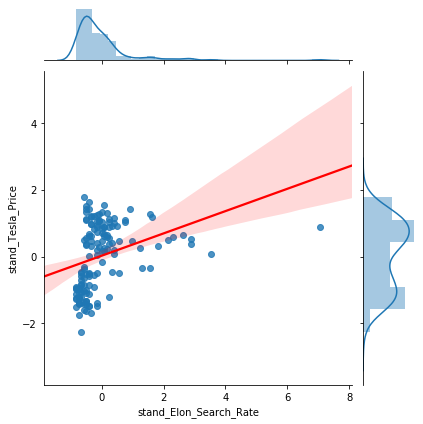

In [51]:
# Display 'Elon Musk' search frequency vs. Tesla Stock Price
sns.jointplot(y='stand_Tesla_Price', x='stand_Elon_Search_Rate', data=final_df, kind='reg', joint_kws={'line_kws':{'color':'red'}})

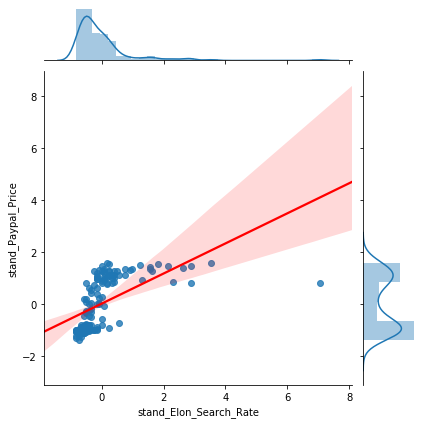

In [52]:
# Display 'Elon Musk' search frequency vs. Paypal Stock Price
sns.jointplot(y='stand_Paypal_Price', x='stand_Elon_Search_Rate', data=final_df, kind='reg', joint_kws={'line_kws':{'color':'red'}})

#### Correlation Coefficients
Our research question is: <em> Is there a correlation between Elon Musk's internet popularity and the performance of TESLA and PAYPAL stocks?</em> We can answer this question by computing the Pearson Correlation Coefficients of our data with pandas' .corr().

In [53]:
#Compute correlations within the data.
final_df[["Tesla_price", "Paypal_price", "Elon_Musk_Search_Rate"]].corr()

,Tesla_price,Paypal_price,Elon_Musk_Search_Rate
Tesla_price,1.000000,0.730257,0.336975
Paypal_price,0.730257,1.000000,0.582043
Elon_Musk_Search_Rate,0.336975,0.582043,1.000000


#### Polarity and Subjectivity Analysis
We want to see concentration of tweets with different polarity and subjectivity ratings. So placed them on a scatter plot. From the plot we can see that objective tweets tend to be more neutral, and highly subjective tweets vary more in polarity.

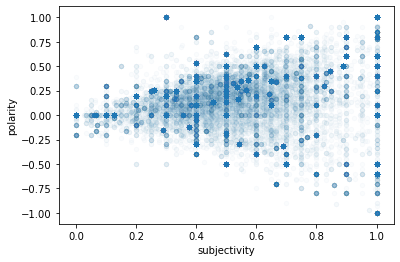

In [65]:
elon_tweets_df.plot.scatter(y = 'polarity', x ='subjectivity', alpha = 0.02)

#### Tweet Frequency
Since we have too little tweet data to search for a correlation between stock performance and twitter sentiment, we instead visualized some histograms to show tweet frequency at different times.

##### Code Description:
We added a new column to the dataframe expressing the day of the week, then we boolean masked our dataframes to divide them by day. Then we made a historgram for each day using pandas' .hist method. We set every axis to have the same length, that way we could better see the volume of tweets across days.

In [66]:
#creates column containing only day
stringArray = []
for d in elon_tweets_df['DateTime']:
    date_as_string = d.isoformat()
    stringArray.append(date_as_string[8:10])
elon_tweets_df['Day'] = stringArray
elon_tweets_df

#boolean masking on day 7
elon_tweets_7 = elon_tweets_df[elon_tweets_df.Day == '07']
#boolean masking on day 6
elon_tweets_6 = elon_tweets_df[elon_tweets_df.Day == '06']
#boolean masking on day 5
elon_tweets_5 = elon_tweets_df[elon_tweets_df.Day == '05']
#boolean masking on day 4
elon_tweets_4 = elon_tweets_df[elon_tweets_df.Day == '04']
#boolean masking on day 3
elon_tweets_3 = elon_tweets_df[elon_tweets_df.Day == '03']
#boolean masking on day 2
elon_tweets_2 = elon_tweets_df[elon_tweets_df.Day == '02']
#boolean masking on day 1
elon_tweets_1 = elon_tweets_df[elon_tweets_df.Day == '01']

Text(0.5, 1.0, 'Reply Frequency on December 1')

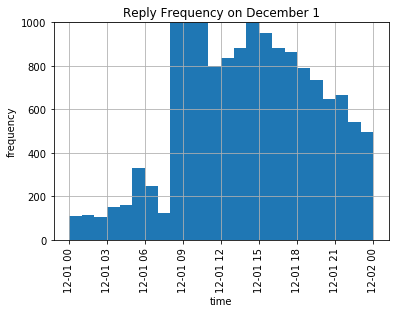

In [67]:
#creates histogram over 24 hour period on day 1, y axis limit set to 1000
plot = elon_tweets_1['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 1')

Text(0.5, 1.0, 'Reply Frequency on December 2')

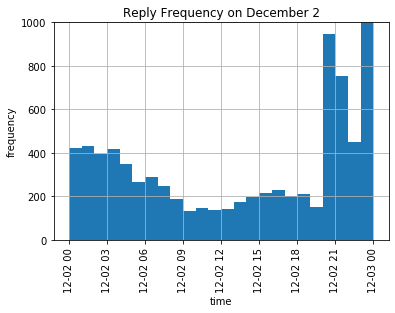

In [68]:
#creates histogram over 24 hour period on day 2, y axis limit set to 1000
plot = elon_tweets_2['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 2')

Text(0.5, 1.0, 'Reply Frequency on December 3')

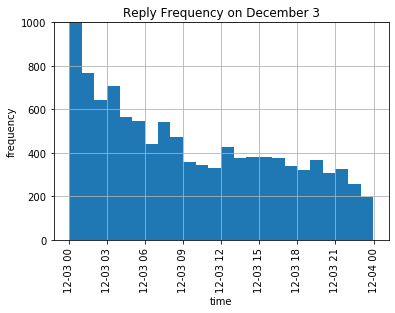

In [69]:
#creates histogram over 24 hour period on day 3, y axis limit set to 1000
plot = elon_tweets_3['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 3')

Text(0.5, 1.0, 'Reply Frequency on December 4')

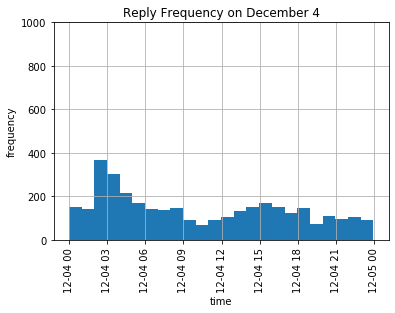

In [70]:
#creates histogram over 24 hour period on day 4, y axis limit set to 1000
plot = elon_tweets_4['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 4')

Text(0.5, 1.0, 'Reply Frequency on December 5')

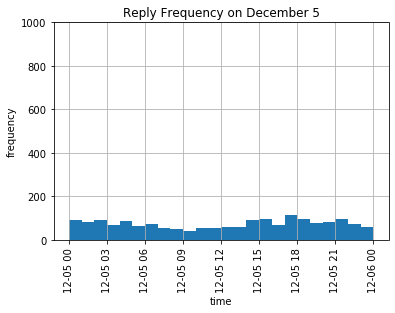

In [71]:
#creates histogram over 24 hour period on day 5, y axis limit set to 1000
plot = elon_tweets_5['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 5')

Text(0.5, 1.0, 'Reply Frequency on December 6')

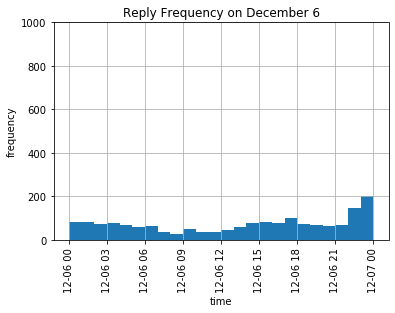

In [72]:
#creates histogram over 24 hour period on day 6, y axis limit set to 1000
plot = elon_tweets_6['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 6')

Text(0.5, 1.0, 'Reply Frequency on December 7')

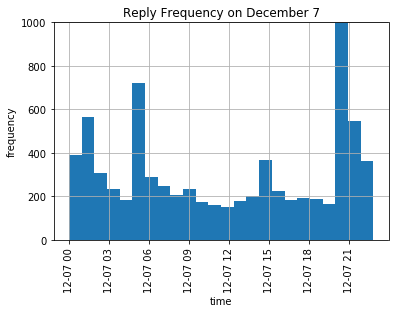

In [73]:
#creates histogram over 24 hour period on day 7, y axis limit set to 1000
plot = elon_tweets_7['DateTime'].hist(bins = 24,xrot = 90).set_ylim(0,1000)
plt.xlabel('time')
plt.ylabel('frequency')
plt.title('Reply Frequency on December 7')

## V. Analysis and Hypothesis Testing
The above confirms our first Hypothesis that <em> 'There will be a positive correlation between Elon Musk's internet popularity and the performance of PAYPAL and TESLA stocks.' </em> Further analyis leads us to conclude that there is a stronger correlation between PAYPAL stock performance and Musk's popularity than TESLA's stock performance.

It is important to note that correlation does not mean causation. Strong correlations can be found between two completely unrelated sets of data. In other words, we can conclude that there is a strong correlation between internet popularity and stock performance. However, we cannot conclude that one of these has any effect on the other.

Our second research question was <em> 'What is a better indicator of stock performance: Twitter or Google Search Trends?'</em> Because our data on Twitter Sentiment is so limitted, we could not conclude anything about which metric is a better indicator. However, we did some interesting visualizations of tweet frequency across different times. From this we can see that there was a large volume of replies to Elon Musk around midnight, December 2. This is probably due to the result of his defamation trial. You can read more about it here: https://www.cnn.com/2019/12/02/media/elon-musk-defamation-tweet/index.html

We can also see that between 10:00 pm and 2:00 am is when Elon Musk receives most of his tweet replies.

## VI. Insight and policy decision
From the experimentation in this project it is very difficult to draw any surefire conclusions. We did confirm a correlation between TESLA/PAYPAL stock performance and internet popularity of Elon Musk. However, since correlation does not mean causation, this is nearly meaningless. Further analysis would be required to draw meaningful conclusions.

If we had more Twitter data, we could make some interesting inferences and final conclusions about our project. We plan to collect data over time to make a machine learning model and calculate linear regressions with more significance.

So to our original question **Can we [Google] the stock market?** Our answer is there is a possibility, but it would be best not to put money on it.